# Renaissance Meter Cladogram

Code and data for preprint Showcase B / Figure 4

In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
from collections import Counter
import metronome as met

In [3]:
from importlib.metadata import version

version("metronome")

'0.1.1'

## Import Data

This data was prepared elsewhere in a different format and is imported here from TSV

In [4]:
df = pd.read_csv("../data/renaissance_metronome.tsv", sep="\t", keep_default_na=False)
df.columns = ["sample", "regularity", "metronome"]
df

,sample,regularity,metronome
0,Venetian_AndreaCalmo,-0.162510,w.S.wSwS.Sw.wS|w.S.wS.w.S.w.wwS|w.w.w.Sw.Sw.w....
1,Catalan_AusiasMarch,-0.233895,S.w.w.S.w.S.wS.w.S|S.wS.S.w.S.w.S.wS|S.w.w.S.w...
2,Portugese_Camoes,-0.087375,w.S.wSw.Sw.SwS|w.Sw.S.w.Sw.Sw.S|w.S.wS.w.Sw.S....
3,Napolitan_Cortese,-0.311954,w.Sw.S.wSw.S.wS|w.w.Sw.wSw.Sw.S|w.S.wSw.S.w.Sw...
4,French_DuBellay,-0.434630,w.w.wS.wwS.w.w.S|ww.wS.w.w.Sw.w.S|w.w.wS.w.S.w...
5,Spanish_deLaTorre,-0.448207,ww.Sw.wSw.w.wS|S.wS.ww.Sw.SwS|Sw.wSw.Sw.wwS|w....
6,Occitan_Gaucelm,-0.335701,w.S.Sw.Sw.w.S.wS|w.w.w.S.w.w.S.w.wS|w.w.S.w.ww...
7,ItalianSicily_daLentini,-0.298419,w.Sw.S.w.Sw.S.w.S|w.S.w.S.wSw.S.w.S|w.S.wSw.S....
8,Frisian_Japics,-0.130157,w.Sw.S.w.S.SSw.S|w.Sw.S.wSw.S.w.S|S.Sw.S.wS.w....
9,German_Opitz,-0.104078,w.w.S.w.w.Sw.Sw.S|w.Sww.w.Sw.Sw.S|w.S.w.S.w.Sw...


In [5]:
def munge(s):
    ary = s.split("_")
    auth = (
        "("
        + "".join(map(lambda x: x if x.islower() else " " + x, ary[1])).lstrip()
        + ")"
    )
    return " ".join([ary[0], auth])


df["sample"] = df["sample"].apply(munge)

In [6]:
df["node"] = df.index + 1

## Run Metronome and Visualize

In [7]:
scorer = met.scoring.Scorer()
dm = scorer.dist_matrix_parallel(df)

2024-04-26 11:38:31,561	INFO worker.py:1749 -- Started a local Ray instance.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 16 rows containing missing values or values outside the scale range
(`geom_label()`). 



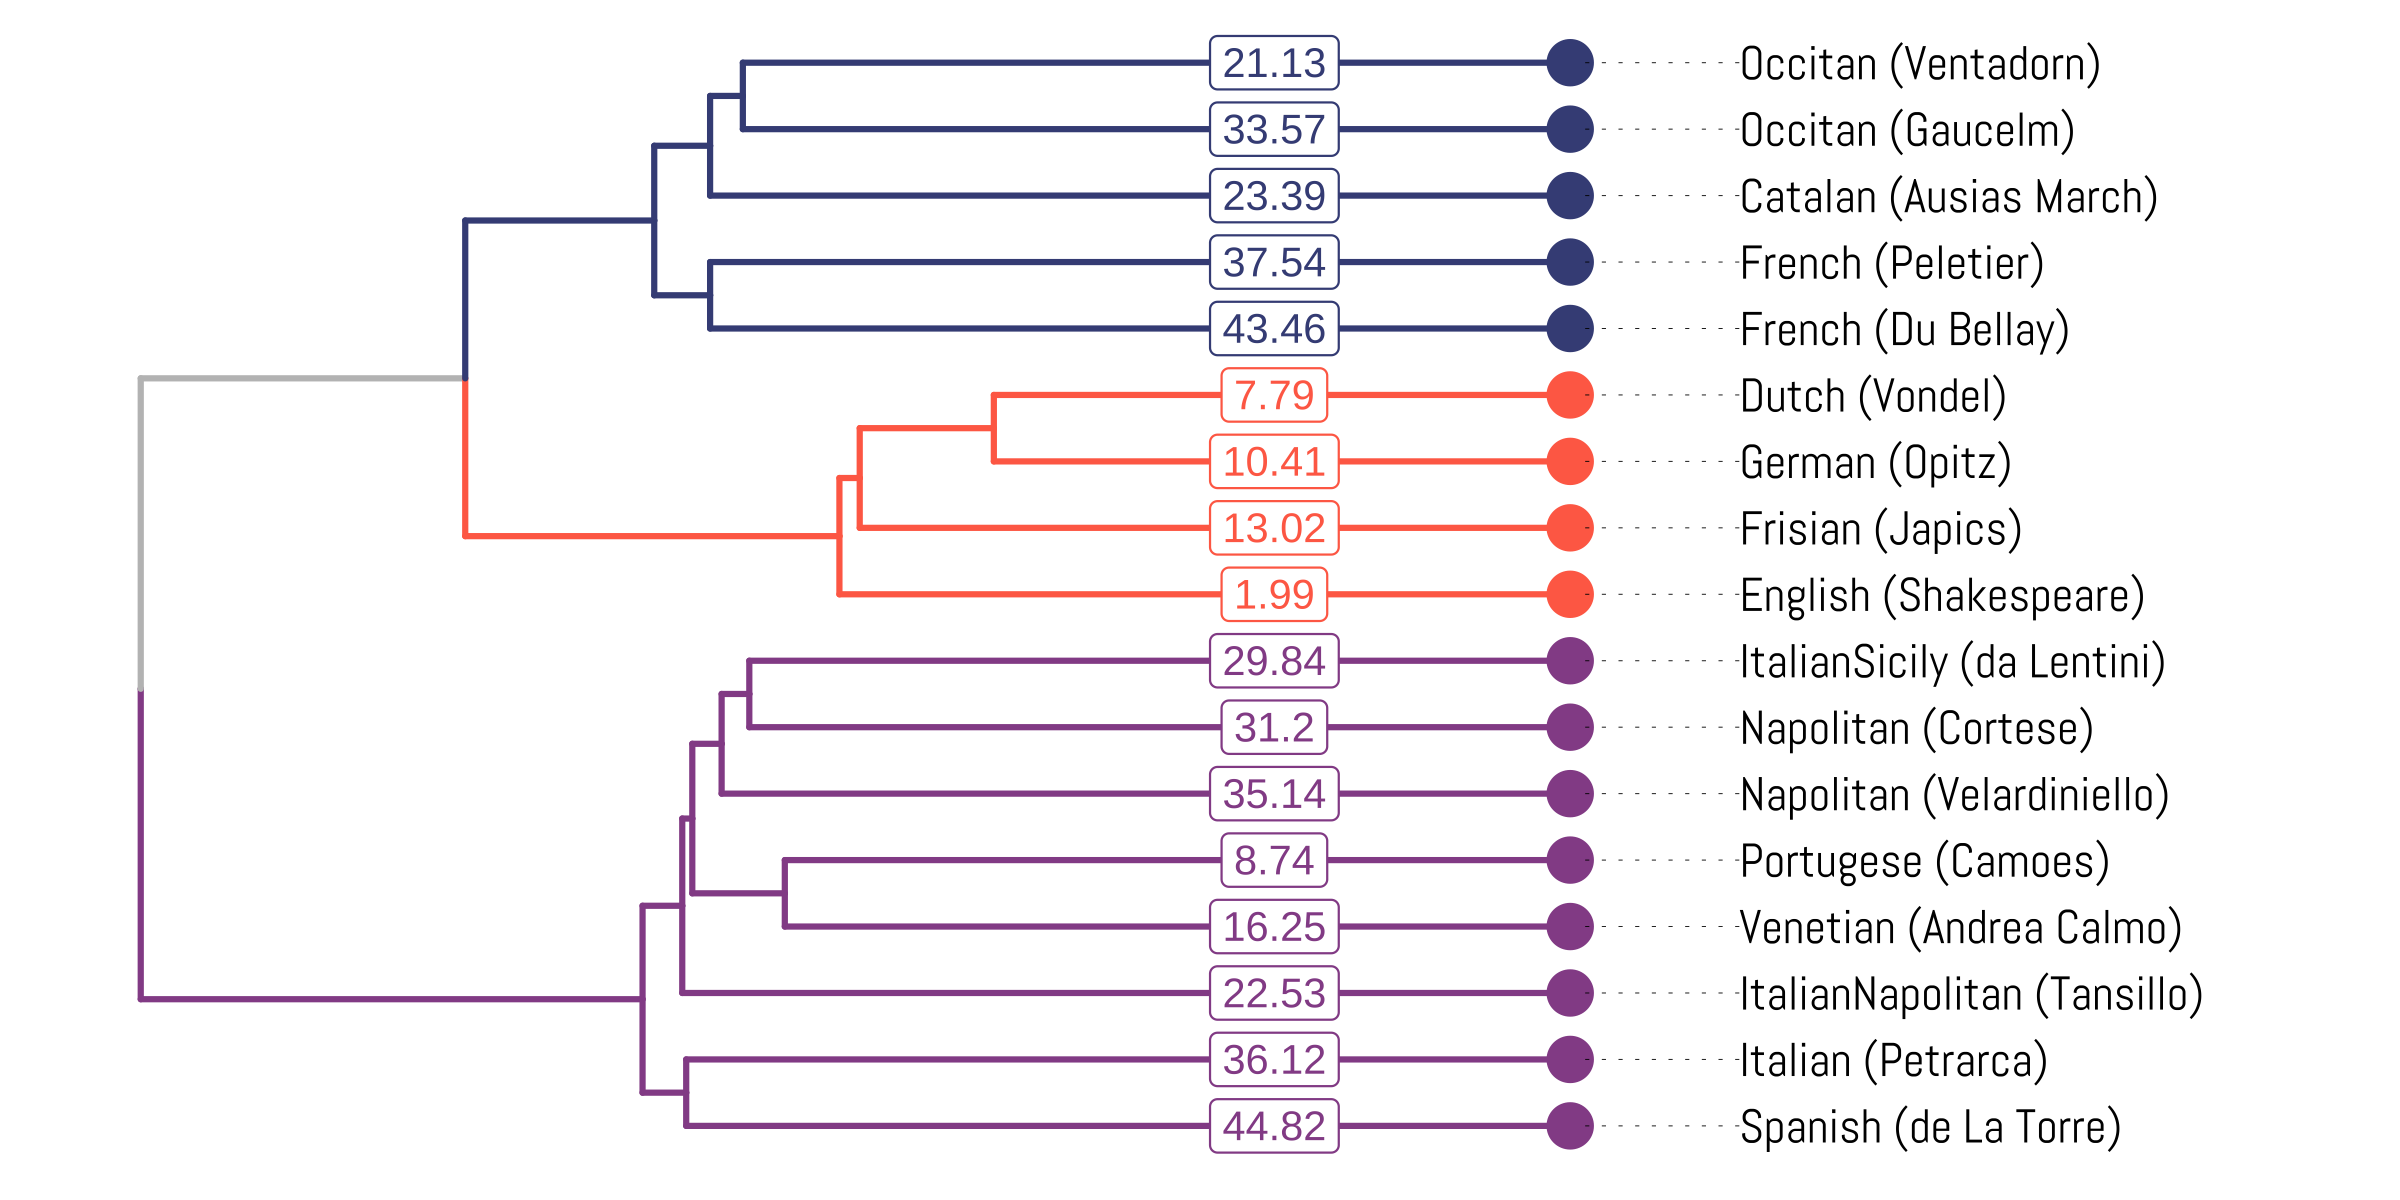

In [9]:
%%R -i dm,df -h 4 -w 8 -u in -r 300

library(ggplot2)
library(dplyr)
library(ggtree)
library(showtext)
library(paletteer)
library(ape)
library(ggnewscale)

showtext_auto()
font_add_google("Abel", "fnt")
plt <- c(
    "grey75", # root node
    "#003f5c",
    "#444e86",
    "#955196",
    "#dd5182",
    "#ff6e54",
    "#ffa600"
)
# manual hack, easier to see
plt[c(2,6)] <- plt[c(6,2)]

# rename to easy copy/paste
m <- dm
df <- df
dm <- as.dist(m)

# do the clustering
hc <- hclust(dm,method='ward.D2')

# manual cluster nodes. hacky.
tree2 <- groupClade(as.phylo(hc), c(21, 22, 19))

p <- ggtree(tree2,aes(color=group), layout="rect",size=0.7,ladderize=T) %<+% df +
geom_tippoint(shape=16,show.legend=F,size=5) +
hexpand(0.4) +
scale_color_manual(values=plt) +
geom_tiplab(aes(label=sample),color='black', family='fnt',align=T,size=4, linetype='dotted',linesize=0.1,offset=0.05) +
# Use this to find the cluster nodes if things change...
#geom_nodelab(aes(label=node),color="black") +
geom_label(aes(x=0.35, label=round(regularity*-100,2)),size=3.5) + 
theme_tree(legend.position = "none")

# fn <- "../paper/figures/ren_dendro.pdf"
# ggsave(fn, plot = p, dpi=600, width=8, height=4, device=cairo_pdf)

p

# This throws a warning about missing labels because we only provide regularity
# data for the tips not the cluster (intermediate) nodes in the tree.


In [10]:
%%R

sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4.1

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Europe/Warsaw
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ggnewscale_0.4.10 ape_5.7-1         paletteer_1.6.0   showtext_0.9-7   
[5] showtextdb_3.0    sysfonts_0.8.9    ggtree_3.11.1     dplyr_1.1.4      
[9] ggplot2_3.5.0    

loaded via a namespace (and not attached):
 [1] yulab.utils_0.1.4  utf8_1.2.4         generics_0.1.3     tidyr_1.3.1       
 [5] ggplotify_0.1.2    lattice_0.22-5     digest_0.6.34      magrittr_2.0.3    
 [9] grid_4.3.3         fastmap_1.1